In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support


sns.set()

In [3]:
CIFAR = np.load('./datasets/CIFAR.npz')
FM0_5 = np.load('./datasets/FashionMNIST0.5.npz')
FM0_6 = np.load('./datasets/FashionMNIST0.6.npz')

In [31]:
def plot_image(dataset):
    fig,axes=plt.subplots(2 ,3,figsize=(10,7))
    for i in range(6):
        if i <3:
            axes[0,i].imshow(dataset['Xtr'][i])
        else: 
            axes[1,i-3].imshow(dataset['Xtr'][i])


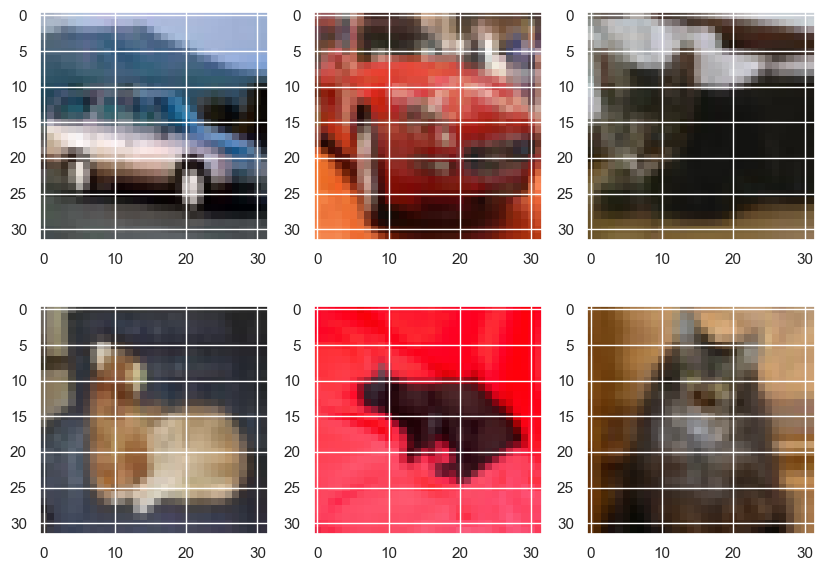

In [32]:
plot_image(CIFAR)

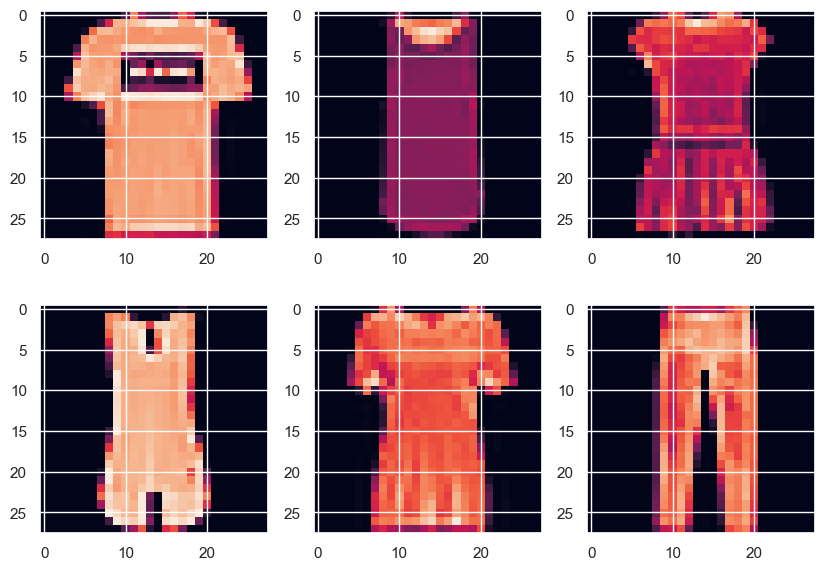

In [33]:
plot_image(FM0_5)

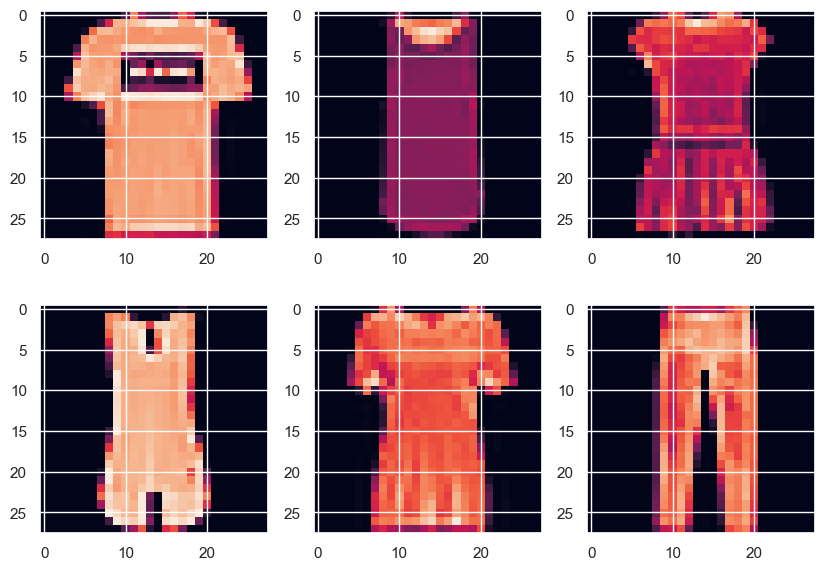

In [34]:
plot_image(FM0_6)

In [73]:
class DatasetArray(Dataset):
    def __init__(self,features,labels):
        self.features=features
        self.labels=labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,index):
        features=self.features[index]
        labels=self.labels[index]
        return (features,labels)

In [138]:
def dataloader(dataset):
    train_features=dataset['Xtr']
    train_labels=dataset['Str']
    train_labels = torch.from_numpy(train_labels)
    train_labels=torch.nn.functional.one_hot(train_labels, num_classes=3).float()
    test_features=dataset['Xts']
    test_labels=dataset['Yts']
    test_labels = torch.from_numpy(test_labels)
    test_labels=torch.nn.functional.one_hot(test_labels, num_classes=3).float()
    x_train,x_val,y_train,y_val=train_test_split(train_features,train_labels,test_size=0.2)
    x_train=torch.from_numpy(x_train.astype(np.float32) / 255).permute(0, 3, 1, 2)
    x_val=torch.from_numpy(x_val.astype(np.float32) / 255).permute(0, 3, 1, 2)
    x_test=torch.from_numpy(test_features.astype(np.float32) / 255).permute(0, 3, 1, 2)
    #batch load
    train_dataset=DatasetArray(x_train,y_train)
    val_dataset=DatasetArray(x_val,y_val)
    test_data=DatasetArray(x_test,test_labels)
    
    train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
    val_loader=DataLoader(val_dataset,batch_size=64,shuffle=True)
    test_loader=DataLoader(test_data,batch_size=64,shuffle=True)

    return train_loader,val_loader,test_loader


In [144]:
train_loader,val_loader,test_loader=dataloader(CIFAR)

In [130]:
class Lenet(nn.Module):
    def __init__(self):
        super(Lenet,self).__init__()
        self.conv1=nn.Conv2d(3,6,5,stride=1,padding=0)
        self.conv2=nn.Conv2d(6,6,5)
        self.fc1=nn.Linear(150,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,3)

    def forward(self,x):
        out=F.relu(self.conv1(x))
        out=F.max_pool2d(out,2)
        out=F.relu(self.conv2(out))
        out=F.max_pool2d(out,2)
        out=out.view(out.size(0),-1)
        out=F.relu(self.fc1(out))
        out=F.relu(self.fc2(out))
        out=self.fc3(out)
        return out
        


In [184]:
def train(model, criterion, optimizer, training_dataloader):
    sum_accuracy = 0
    sum_loss = 0
    count = 0
    model.train()
    for features, labels in training_dataloader:
        probabilities=model(features)
        #print(probabilities)
        loss=criterion(probabilities,labels)
        #print(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        mini_batch_size=labels.size(0)
        labels=torch.argmax(labels, dim=1)
        accuracy=(
            torch.sum(torch.max(probabilities,dim=1).indices==labels)
        )

        sum_accuracy+=accuracy.item()
        sum_loss+=loss.item()*mini_batch_size
        #print(sum_loss)
        count+=mini_batch_size
        #print(sum_loss/count)
        train_acc=sum_accuracy/count
        train_loss=sum_loss/count
    return train_acc, train_loss



In [188]:
def validate(model,criterion,dataloader):
    sum_accuracy=0
    sum_loss=0
    count=0
    model.eval()
    for features ,labels in dataloader:
        
        with torch.no_grad():
            probabilities=model(features)
            loss=criterion(probabilities,labels)
        mini_batch_size=labels.size(0)
        labels=torch.argmax(labels, dim=1)
        accuracy=(
            torch.sum(torch.max(probabilities,dim=1).indices==labels)
        )

        sum_accuracy+=accuracy.item()
        sum_loss+=loss.item()*mini_batch_size
        #print(sum_loss)
        count+=mini_batch_size
        #print(sum_loss/count)
        val_acc=sum_accuracy/count
        val_loss=sum_loss/count
    return val_acc, val_loss
    

In [187]:
def evaluate(dataset,model):
    x_test=dataset["Xts"]
    y_test=dataset["Yts"]
    x_test=torch.from_numpy(x_test.astype(np.float32) / 255).permute(0, 3, 1, 2)
    cifar_xtest=torch.Tensor(x_test)
    y_pred=torch.max(model(cifar_xtest),dim=1).indices
    correct=0
    for index , value in enumerate(y_pred):
        if value == y_test[index]:
            correct += 1
    #report=classification_report(y_test,y_pred.numpy())
    precision,recall,_,_=precision_recall_fscore_support(y_test,y_pred,average='weighted')
    return precision, recall

In [196]:
def run(dataset,epochs=10,lr=0.01):

    train_loader,val_loader,test_loader=dataloader(dataset)
    model=Lenet()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        train_acc, train_loss=train(model,criterion, optimizer, train_loader)
        val_acc, val_loss=validate(model,criterion, val_loader)
        test_acc, test_loss=validate(model,criterion, test_loader)

        training_accuracies.append(train_acc)
        training_losses.append(train_loss)
        validation_accuracies.append(val_acc)
        validation_losses.append(val_loss)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)


        print(f"epoch: {epoch}\n \
            train_acc: {train_acc}, train_loss: {train_loss}\n \
            val_acc: {val_acc}, val_loss: {val_loss}\n \
            test_acc: {test_acc}, test_loss: {test_loss}\n")
    precision,recall=evaluate(dataset,model)


    return (training_accuracies,training_losses,
            validation_accuracies,
            validation_losses,
            test_accuracies,
            test_losses,
            precision,
            recall,
            model)


        



In [190]:
def plot(run,acc,loss):
    for i in run:
        df=pd.DataFrame()
        df['train_acc_df']=pd.DataFrame(acc[i])
        df['train_loss_df']=pd.DataFrame(loss[i])
        plt.plot(df['train_acc_df'], label='train_acc_df')
        plt.plot(df['train_loss_df'], label='train_loss_df')
        plt.legend()
        # 添加标签和标题
        plt.xlabel('Index')
        plt.ylabel('Values')


In [201]:
(training_accuracies,training_losses,
validation_accuracies,
validation_losses,
test_accuracies,
test_losses,
precision,
recall,
model)=run(CIFAR,epochs=40,lr=0.01)

epoch: 0
             train_acc: 0.33116666666666666, train_loss: 1.0993518505096436
             val_acc: 0.342, val_loss: 1.0983658374150593
             test_acc: 0.3333333333333333, test_loss: 1.0981972812016805

epoch: 1
             train_acc: 0.33075, train_loss: 1.0987221091588337
             val_acc: 0.353, val_loss: 1.0984906091690063
             test_acc: 0.39566666666666667, test_loss: 1.098029055595398

epoch: 2
             train_acc: 0.3315, train_loss: 1.098613005956014
             val_acc: 0.32666666666666666, val_loss: 1.0985832433700562
             test_acc: 0.36, test_loss: 1.0979716339111327

epoch: 3
             train_acc: 0.342, train_loss: 1.0985799843470256
             val_acc: 0.313, val_loss: 1.0985543820063273
             test_acc: 0.3566666666666667, test_loss: 1.0979092601140341

epoch: 4
             train_acc: 0.33508333333333334, train_loss: 1.098554033279419
             val_acc: 0.3473333333333333, val_loss: 1.098559794108073
             test_

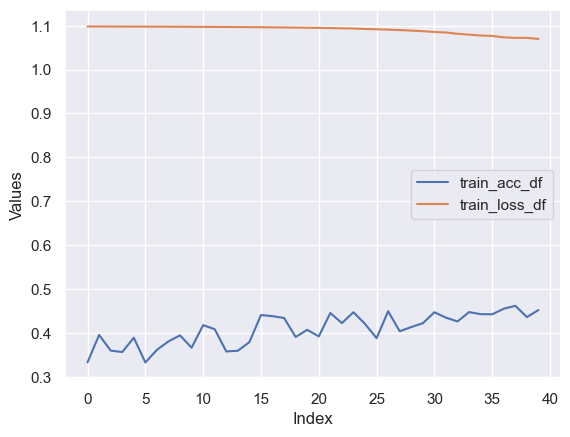

In [203]:
plot(test_accuracies,test_losses)